In [1]:
import pandas as pd
import numpy as np
import cv2
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense, Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as img
import seaborn as sns
from keras.models import  Sequential,Model 
from sklearn.metrics import f1_score
from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64
import tensorflow as tf
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
IMG_WIDTH = 178
IMG_HEIGHT = 218

In [3]:
image_folder="/Users/Rj/celaba-datase/img_align_celeba/img_align_celeba/"
main="/Users/Rj/celaba-datase/"
ex_pic=image_folder + '000015.jpg'
df_par=pd.DataFrame()

In [4]:
df=pd.read_csv("/Users/Rj/celaba-datase/list_attr_celeba.csv")
df.replace(to_replace=-1,value=0,inplace=True)
df.set_index('image_id',inplace=True)
df.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [5]:
df.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [6]:
df_partition=pd.read_csv(main+'list_eval_partition.csv')
df_partition.replace(to_replace=-1,value=0,inplace=True)
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [7]:
df_partition['partition'].value_counts().sort_index()
# 0=Training
# 1=Validation
# 2=Testing

0    162770
1     19867
2     19962
Name: partition, dtype: int64

Brown_Hair       0
Blond_Hair       0
Black_Hair       0
Gray_Hair        0
Young            0
Straight_Hair    1
Wavy_Hair        0
Name: 000015.jpg, dtype: int64

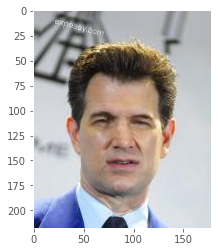

In [8]:
image=load_img(ex_pic)
plt.grid(False)
plt.imshow(image)
df.loc[ex_pic.split('/')[-1]][['Brown_Hair','Blond_Hair','Black_Hair','Gray_Hair','Young','Straight_Hair','Wavy_Hair']]

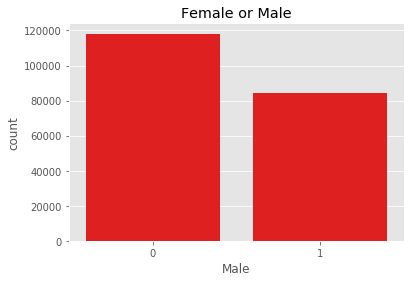

In [9]:
plt.title('Female or Male')
sns.countplot(x='Male',data=df,color='r')
plt.show()

In [10]:
df_partition.set_index('image_id',inplace=True)
df_par0=df_partition.join(df['Male'],how='inner')

In [11]:
df_par1=df['Straight_Hair']

In [12]:
df_par0.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [13]:
df_par1.head()

image_id
000001.jpg    1
000002.jpg    0
000003.jpg    0
000004.jpg    1
000005.jpg    0
Name: Straight_Hair, dtype: int64

In [14]:
df_par=pd.concat([df_par0,df_par1],axis=1)

In [15]:
df_par.head()

,partition,Male,Straight_Hair
image_id,,,
000001.jpg,0,0,1
000002.jpg,0,0,0
000003.jpg,0,1,0
000004.jpg,0,0,1
000005.jpg,0,0,0


In [16]:
def reshape(name):
    image=load_img(name)
    i=img_to_array(image)/255
    i=i.reshape((1,)+i.shape)
    return i

In [17]:
def generate_df(partition,attribute,number_sample):
    
    dfx=df_par[ (df_par['partition']==partition ) & (df_par[attribute]==0)].sample(int(number_sample/2))
    dfx=pd.concat( [dfx,df_par[ (df_par['partition']==partition)&( df_par[attribute]==1)].sample(int(number_sample/2))])

    if partition==2:
        x=[]
        y=[]
        for index, target in dfx.iterrows():
            im=cv2.imread(image_folder+index)
            im=cv2.resize(cv2.cvtColor(im,cv2.COLOR_BGR2RGB),(IMG_WIDTH,IMG_HEIGHT)).astype(np.float32)/255.0
            im=np.expand_dims(im,axis=0)
            x.append(im)
            y.append(target[attribute])
    else:
            x=np.array([reshape(image_folder+name)for name in dfx.index])
            x=x.reshape(x.shape[0],218,178,3)
            y=np_utils.to_categorical(dfx[attribute],2)
    return x,y

In [18]:
X_train,y_train=generate_df(0,'Male',15000)

train_pre=ImageDataGenerator( featurewise_center=True,
    featurewise_std_normalization=True,rotation_range=30,width_shift_range=0.2,
                           height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
train_pre.fit(X_train)
train_pre=train_pre.flow(X_train,y_train,32)

In [19]:
from sklearn.model_selection import train_test_split
label=df_par['partition']
feat=['Male','Straight_Hair']
df_feat=df_par[feat]
x_train,x_test,Y_train,Y_test=train_test_split(df_feat,label,test_size=.10,random_state=40)

In [20]:
model=Sequential()
model.add(Convolution2D(32,(3,3), activation='relu', data_format="channels_last", input_shape=(218,178,3)))
print(model.output_shape)

(None, 216, 176, 32)


In [21]:
model.add(Convolution2D(32, (3,3), activation='relu'))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2,2)))
print(model.output_shape)
          
model.add(Dropout(0.25))

(None, 214, 174, 32)
(None, 107, 87, 32)


In [22]:
model.add(Flatten())
print(model.output_shape)

model.add(Dense(120, activation='relu'))
print(model.output_shape)

model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
print(model.output_shape)

(None, 297888)
(None, 120)
(None, 2)


In [23]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 216, 176, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 214, 174, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 107, 87, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 107, 87, 32)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 297888)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               35746680  
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)              

In [24]:
X_train.shape

(15000, 218, 178, 3)

In [25]:
y_train.shape
for i in range(0,10):
    print(y_train)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [26]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
fitted_model = model.fit(X_train, y_train, validation_split=0.25, batch_size=20, epochs=5, verbose=1)

Train on 11250 samples, validate on 3750 samples
Epoch 1/5
11250/11250 [==============================] - 1066s 95ms/step - loss: 0.4390 - accuracy: 0.8425 - val_loss: 0.4261 - val_accuracy: 0.8131
Epoch 2/5
11250/11250 [==============================] - 1044s 93ms/step - loss: 0.1907 - accuracy: 0.9236 - val_loss: 0.3597 - val_accuracy: 0.8496
Epoch 3/5
11250/11250 [==============================] - 1159s 103ms/step - loss: 0.1239 - accuracy: 0.9517 - val_loss: 0.2150 - val_accuracy: 0.9101
Epoch 4/5
11250/11250 [==============================] - 1198s 106ms/step - loss: 0.0877 - accuracy: 0.9670 - val_loss: 0.3775 - val_accuracy: 0.8563
Epoch 5/5
11250/11250 [==============================] - 1014s 90ms/step - loss: 0.0597 - accuracy: 0.9787 - val_loss: 0.4232 - val_accuracy: 0.8677


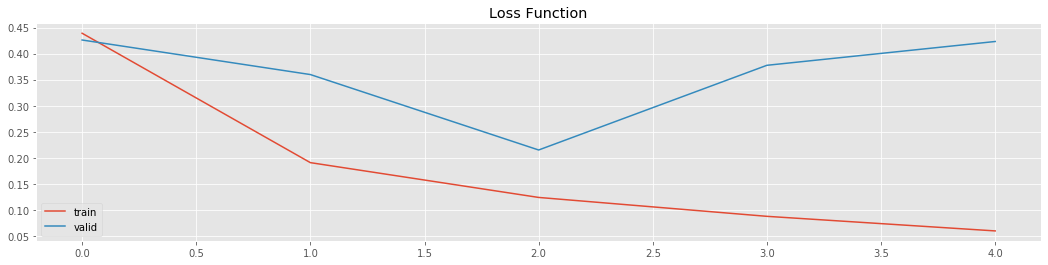

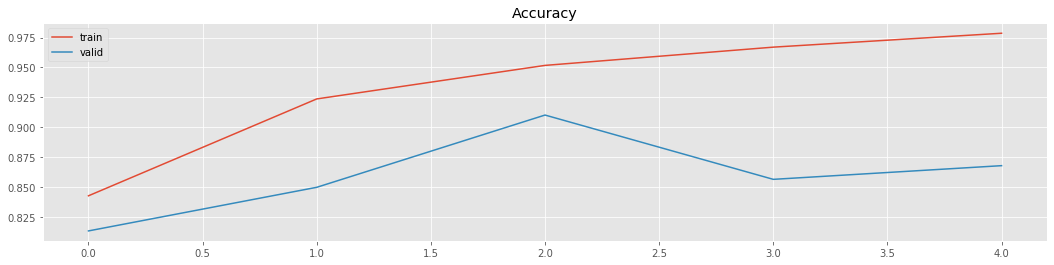

In [34]:
plt.figure(figsize=(18, 4))
plt.plot(fitted_model.history['loss'], label = 'train')
plt.plot(fitted_model.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(fitted_model.history['accuracy'], label = 'train')
plt.plot(fitted_model.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [27]:
x_train.shape

(182339, 2)

In [28]:
# Test Data
x_test, y_test = generate_df(2, 'Male', 3000)

# generate prediction
model_predictions = [np.argmax(model.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 90.8667%
f1_score: 0.9060356652949246


In [29]:
#dictionary to name the prediction
gender_target = {0: 'Female', 1: 'Male'}
hair={0:'Wavy hair',1:'Straight Hair'}
def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):

    gender = 'Male'
   
    #gender_icon = "https://i.imgur.com/nxWan2u.png"
        
    if prediction[1] <= 0.5:
      #  gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'
    
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: 15px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: 15px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: 15px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)

               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))
    

In [30]:
def gender_prediction(filename):
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model.predict(im)
    prediction = np.argmax(result)
    
    return result


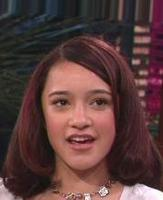


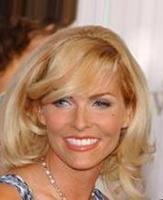


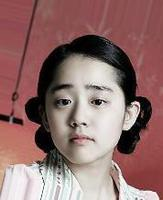


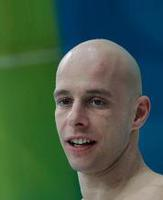


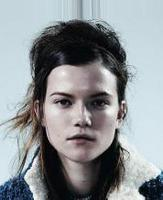


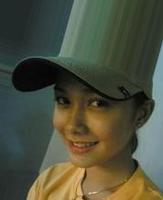


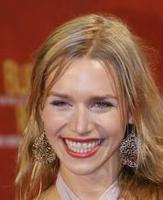


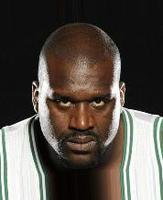

In [31]:
#select random images of the test partition
df_to_test = df_par[(df_par['partition'] == 2)].sample(8)

for index, target in df_to_test.iterrows():
    result = gender_prediction(image_folder + index)
    
    #display result
    display_result(image_folder + index, result[0], target['Male'])